# This notebook outlines the data processing approach for the JOC article
    
To access the data and run the notebooks, you must perform the following steps:

1) Navigate to http://tiny.cc/JOC-XX-XXXX, where the XX-XXXX is the manuscript number on manuscript central.

2) Download the file, named data.tar.gz.  It has the following checksum information

![title](checksum.jpg)

3) ungz and untar the folder 'data' into the mcs_future folder. These files represent post-processed data and not the entire dataset.  This is due to the very large size of the three datasets, the raw derived data, and the amount of time it takes to run the training and classification.  However, applying the methods of this paper to the publically available data will give you the same results. If you downloaded the entire github project, the directories for the data folder and its subfolders should be:

/MCS/mcs_future/data/raw_data

/MCS/mcs_future/data/shapefiles

/MCS/mcs_future/data/slice_data

/MCS/mcs_future/data/wrf_data

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import sys
sys.path.append('C:/users/ahaberlie/documents/github/MCS/')

data_dir = ""

data = {'mcs':{'OBS':None, 'CTRL':None, 'PGW':None},
        'qlcs':{'OBS':None, 'CTRL':None, 'PGW':None},
        'non_qlcs':{'OBS':None, 'CTRL':None, 'PGW':None}}

for subset in ['mcs', 'qlcs', 'non_qlcs']:
    
    filename = data_dir + "new_{}_project.csv".format(subset)
    
    df = pd.read_csv(filename)
    df['datetime'] = pd.to_datetime(df.datetime)
    df = df.set_index('datetime')
    
    for dataset in ['OBS', 'CTRL', 'PGW']:

        data[subset][dataset] = df[df.run.values==dataset].copy()

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

def draw_states(ax):
        
    shapename = 'admin_1_states_provinces_lakes_shp'
    states_shp = shpreader.natural_earth(resolution='50m',
                                     category='cultural', name=shapename)

    for state, info in zip(shpreader.Reader(states_shp).geometries(), shpreader.Reader(states_shp).records()):
        if info.attributes['admin'] == 'United States of America':

            ax.add_geometries([state], ccrs.PlateCarree(),
                              facecolor='None', edgecolor='k')
                              
def draw_midwest(ax):
    
    shapename = "../data/shapefiles/map/midwest_outline_latlon_grids"
    shp = shpreader.Reader(shapename)
    for outline, info in zip(shp.geometries(), shp.records()):
        ax.add_geometries([outline], ccrs.PlateCarree(),
                          facecolor='None', edgecolor='k', linewidth=4)
        
def generate_view(w_lon, e_lon, n_lat, s_lat, from_proj, to_proj):

    view = plt.axes([0,0,1,1], projection=to_proj)

    view.set_extent([w_lon, e_lon, s_lat, n_lat])

    shapename = 'admin_1_states_provinces_lakes_shp'
    states_shp = shpreader.natural_earth(resolution='50m',
                                         category='cultural', name=shapename)

    for state, info in zip(shpreader.Reader(states_shp).geometries(), shpreader.Reader(states_shp).records()):
        if info.attributes['admin'] == 'United States of America':

            view.add_geometries([state], ccrs.PlateCarree(),
                              facecolor='None', edgecolor='k')
            
    return view

# Draw all June - August OBS tracks

In [3]:
from netCDF4 import Dataset

#grid lats and lons
nc = Dataset("../data/wrf_data/RALconus4km_wrf_constants.nc")
lons = nc.variables['XLONG'][:,:]
lats = nc.variables['XLAT'][:,:]

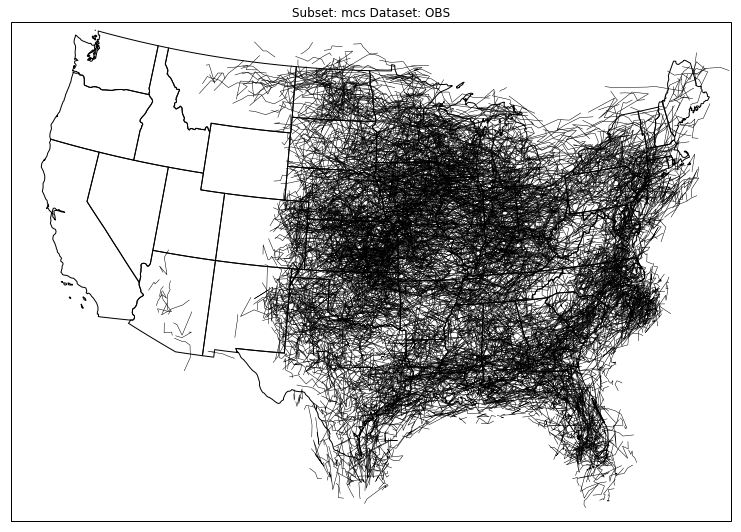

In [4]:
import cartopy
import cartopy.crs as ccrs
from mcs_future.utils.mapping_help import wrf_to_lon_lat
import matplotlib.pyplot as plt
from netCDF4 import Dataset
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 10

from_proj = ccrs.PlateCarree()
to_proj = ccrs.AlbersEqualArea(central_longitude=-95, central_latitude=38.0000)

view = generate_view(-120, -73, 20, 50, from_proj, to_proj)

subset = 'mcs'
dataset = 'OBS'
df_ = data[subset][dataset].copy()
df_ = df_[df_.index.month.isin([6,7,8])]

for sid, swath in df_.groupby('storm_num'):

    xp = np.array([np.mean([x1, x2]) for (x1, x2) in zip(swath.xmin.values, swath.xmax.values)])
    yp = np.array([np.mean([y1, y2]) for (y1, y2) in zip(swath.ymin.values, swath.ymax.values)])

    xp, yp = wrf_to_lon_lat(lons, lats, xp.astype(int), yp.astype(int))

    view.plot(xp, yp, 'k-', lw=0.5, transform=from_proj)
    view.set_title("Subset: " + subset + " Dataset: " + dataset)

# Draw all June - August CTRL Tracks

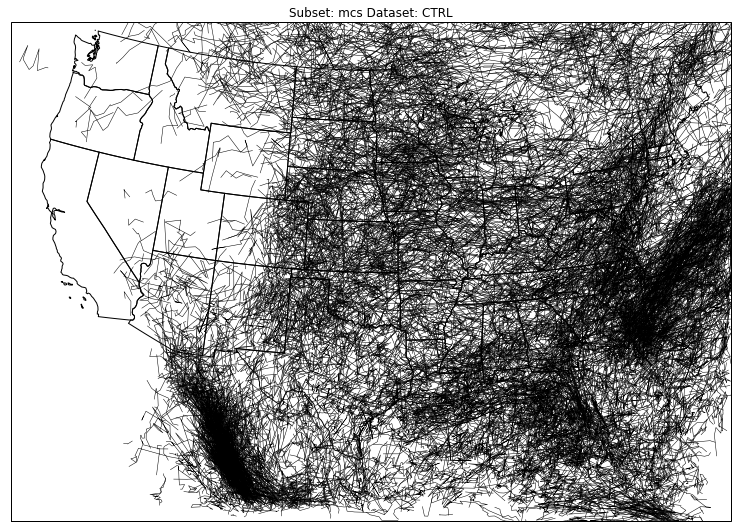

In [5]:
import cartopy
import cartopy.crs as ccrs
from mcs_future.utils.mapping_help import wrf_to_lon_lat
import matplotlib.pyplot as plt
from netCDF4 import Dataset
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 10

from_proj = ccrs.PlateCarree()
to_proj = ccrs.AlbersEqualArea(central_longitude=-95, central_latitude=38.0000)

view = generate_view(-120, -73, 20, 50, from_proj, to_proj)

subset = 'mcs'
dataset = 'CTRL'
df_ = data[subset][dataset]
df_ = df_[df_.index.month.isin([6,7,8])]

for sid, swath in df_.groupby('storm_num'):

    xp = np.array([np.mean([x1, x2]) for (x1, x2) in zip(swath.xmin.values, swath.xmax.values)])
    yp = np.array([np.mean([y1, y2]) for (y1, y2) in zip(swath.ymin.values, swath.ymax.values)])

    if dataset == 'OBS':
        xp, yp = NOWrad_to_lon_lat(xp, yp)
    else:
        xp, yp = wrf_to_lon_lat(lons, lats, xp.astype(int), yp.astype(int))

    view.plot(xp, yp, 'k-', lw=0.5, transform=from_proj)
    view.set_title("Subset: " + subset + " Dataset: " + dataset)

# Get only those tracks that intersect the Midwest

In [6]:
import sys
import geopandas as gpd
from mcs_future.utils.mapping_help import get_point_subset

mw_shp_dir = "../data/shapefiles/map/"
wrf_dir = "../data/wrf_data/"
wrf_data_file = "RALconus4km_wrf_constants.nc"

mw_data = {'mcs':{'OBS':None, 'CTRL':None, 'PGW':None},
           'qlcs':{'OBS':None, 'CTRL':None, 'PGW':None},
           'non_qlcs':{'OBS':None, 'CTRL':None, 'PGW':None}}

outline = gpd.read_file(mw_shp_dir + "midwest_outline_latlon_grids.shp")

for sub_key, sub_value in data.items():
    
    for dset_key, dset_val in sub_value.items():
        mw_data[sub_key][dset_key] = get_point_subset(dset_val.copy(), 
                                                      outline, wrf_dir + wrf_data_file)

# Draw OBS QLCS tracks that intersect Midwest

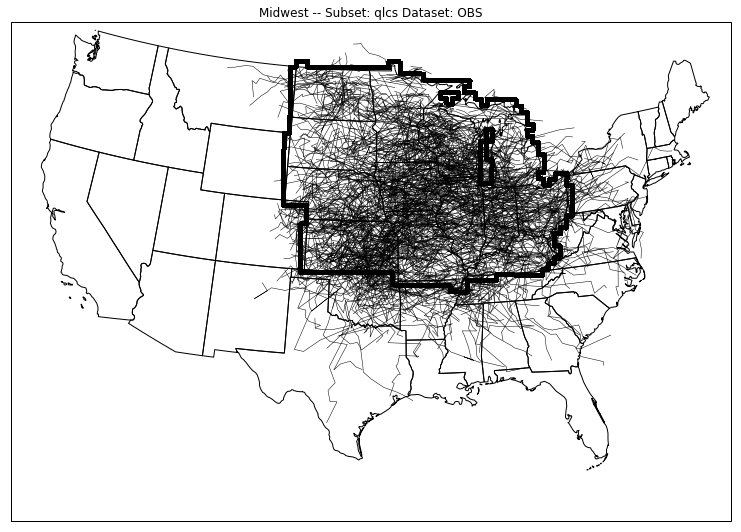

In [7]:
view = generate_view(-120, -73, 20, 50, from_proj, to_proj)

subset = 'qlcs'
dataset = 'OBS'
df_ = mw_data[subset][dataset].copy()
df_ = df_[df_.index.month.isin([6,7,8])]

for sid, swath in df_.groupby('storm_num'):

    xp = np.array([np.mean([x1, x2]) for (x1, x2) in zip(swath.xmin.values, swath.xmax.values)])
    yp = np.array([np.mean([y1, y2]) for (y1, y2) in zip(swath.ymin.values, swath.ymax.values)])

    xp, yp = wrf_to_lon_lat(lons, lats, xp.astype(int), yp.astype(int))

    view.plot(xp, yp, 'k-', lw=0.5, transform=from_proj)
    view.set_title("Midwest -- Subset: " + subset + " Dataset: " + dataset)
    
    draw_midwest(view)

# Draw CTRL QLCS tracks that intersect Midwest

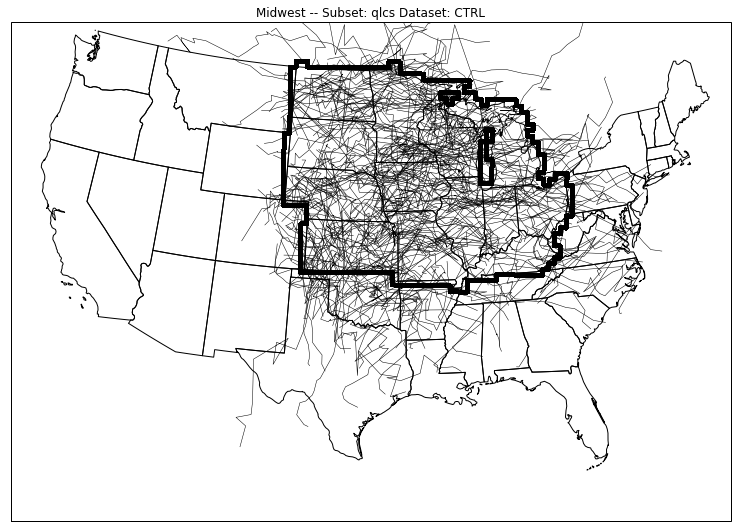

In [8]:
view = generate_view(-120, -73, 20, 50, from_proj, to_proj)

subset = 'qlcs'
dataset = 'CTRL'
df_ = mw_data[subset][dataset]
df_ = df_[df_.index.month.isin([6,7,8])]

for sid, swath in df_.groupby('storm_num'):

    xp = np.array([np.mean([x1, x2]) for (x1, x2) in zip(swath.xmin.values, swath.xmax.values)])
    yp = np.array([np.mean([y1, y2]) for (y1, y2) in zip(swath.ymin.values, swath.ymax.values)])

    if dataset == 'OBS':
        xp, yp = NOWrad_to_lon_lat(xp, yp)
    else:
        xp, yp = wrf_to_lon_lat(lons, lats, xp.astype(int), yp.astype(int))

    view.plot(xp, yp, 'k-', lw=0.5, transform=from_proj)
    view.set_title("Midwest -- Subset: " + subset + " Dataset: " + dataset)
    draw_midwest(view)

# Get counts of days from Midwest

In [9]:
import datetime
from scipy.misc import imread

def calc_day_count(dframe):
    
    #Resample and calculate how many rows each day has
    days = dframe.resample('D').count()
    
    #Give me the count of days with at least one row
    return np.sum(days['storm_num'].values > 0)

# Example of how Days vs. Event Counts Calculated

qlcs day counts: 4 ; percent of days examined: 0.571428571429
qlcs swath counts: 8


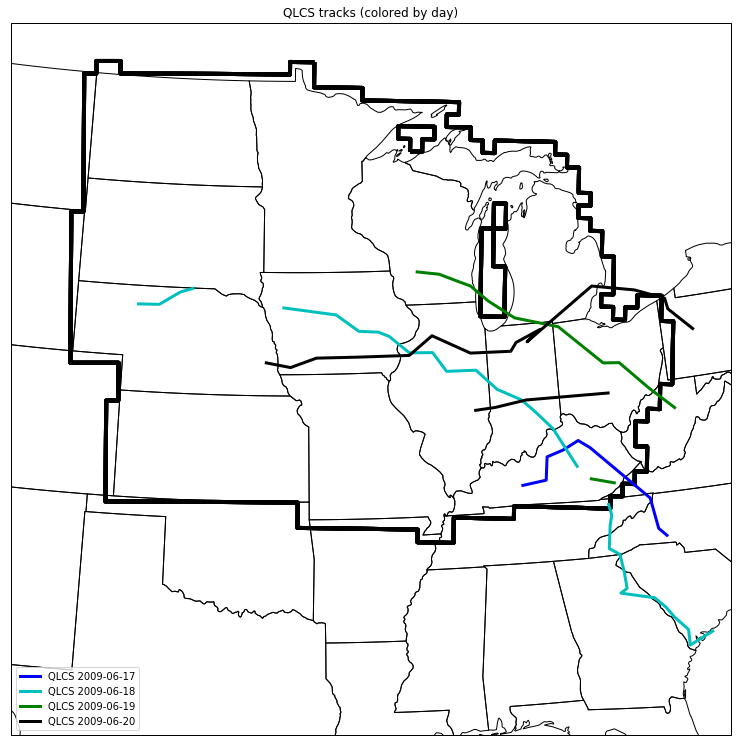

In [10]:
from mcs_future.utils.mapping_help import draw_midwest

#Read in all observed qlcs events
dataset = 'OBS'
subset = 'qlcs'

#Read in a copy of this dataset.  This is important because
#we will be modifying the index (a datetime) to simplify the
#Day Count calculation
a = mw_data[subset][dataset].copy()

#Add 6 hours to the datetime so 18z is now centered at 00z
a.index = a.index + datetime.timedelta(hours=6)

#set year, month, and range of days
year = 2009
month = 6

#look at 
day_range = np.array(list(range(17, 24)))

#make temporary month/year dataframe
b = a[(a.index.year==year) & ((a.index.month==month)) & (a.index.day.isin(day_range))]

#try to select 8 or fewer days or this won't work that well
colors = ['b', 'c', 'g', 'k', 'm', 'r', 'grey', 'y']

lines = []
labels = []

#set up view centered on midwest
view = generate_view(-105, -80, 30, 50, from_proj, to_proj)

#plot tracks by day
for color, day in zip(colors, day_range):

    df_ = b[b.index.day==day]
    for sid, sw in df_.groupby('storm_num'):

        if len(sw) > 0:
            xp = np.array([np.mean([x1, x2]) for (x1, x2) in zip(sw.xmin.values, sw.xmax.values)])
            yp = np.array([np.mean([y1, y2]) for (y1, y2) in zip(sw.ymin.values, sw.ymax.values)])

            xp, yp = wrf_to_lon_lat(lons, lats, xp.astype(int), yp.astype(int))

            view.plot(xp, yp, '-', lw=3, color=color, transform=from_proj, 
                      label=subset.upper() + " " + str(year) + "-" + str(month).zfill(2) + "-" + str(day).zfill(2))

    view.set_title(subset.upper() + " tracks (colored by day)")

    draw_midwest(view)

c = a[(a.index.year==year) & (a.index.month==month) & (a.index.day.isin(day_range))]

print(subset + " day counts:", calc_day_count(c), "; percent of days examined:", calc_day_count(c) / len(day_range))
print(subset + " swath counts:", c.storm_num.nunique())

view.legend(loc=3)

In [11]:
import numpy as np

for sub_key in ['mcs', 'qlcs', 'non_qlcs']:
    
    for dset_key in ['OBS', 'CTRL', 'PGW']:
        
        #copy the desired dataset and subset
        dset_val = mw_data[sub_key][dset_key].copy()
        
        #Get running count of slices per storm
        dset_val['storm_run'] = dset_val.groupby(['storm_num']).cumcount()
        
        #Shift 18z to 00z for analysis purposes
        dset_val.index = dset_val.index + datetime.timedelta(hours=6)
        
        total_count = calc_day_count(dset_val)
        
        seasons = {'djf':(12, 1, 2), 'mam':(3, 4, 5), 'jja':(6, 7, 8), 'son':(9, 10, 11)}
        
        for season_id, season_vals in seasons.items():
            
            dset_ = dset_val[dset_val.index.month.isin(season_vals)].copy()
            perc = "{0:.2f}".format(100*(calc_day_count(dset_) / total_count)) 
            seasons[season_id] = perc
        
        print(sub_key, dset_key, "Total Count:", total_count, 
              ", % DJF", seasons['djf'], ', % MAM', seasons['mam'], 
              ', % JJA', seasons['jja'], ', % SON', seasons['son'], '\n')    


mcs OBS Total Count: 1850 , % DJF 3.78 , % MAM 29.24 , % JJA 48.70 , % SON 18.27 

mcs CTRL Total Count: 1804 , % DJF 4.82 , % MAM 33.37 , % JJA 45.79 , % SON 16.02 

mcs PGW Total Count: 1953 , % DJF 7.37 , % MAM 35.28 , % JJA 37.58 , % SON 19.76 

qlcs OBS Total Count: 1256 , % DJF 3.98 , % MAM 28.90 , % JJA 51.27 , % SON 15.84 

qlcs CTRL Total Count: 811 , % DJF 4.69 , % MAM 38.35 , % JJA 42.91 , % SON 14.06 

qlcs PGW Total Count: 954 , % DJF 7.34 , % MAM 43.82 , % JJA 32.39 , % SON 16.46 

non_qlcs OBS Total Count: 1199 , % DJF 2.42 , % MAM 28.86 , % JJA 50.88 , % SON 17.85 

non_qlcs CTRL Total Count: 1482 , % DJF 3.71 , % MAM 31.78 , % JJA 49.33 , % SON 15.18 

non_qlcs PGW Total Count: 1636 , % DJF 6.48 , % MAM 34.05 , % JJA 40.16 , % SON 19.32 



# Show monthly percentages of events

In [12]:
from calendar import month_name as mname

col_names = ['key'] + [str(x) for x in range(1, 13)]

months = {x:[] for x in col_names}

for sub_key in ['mcs', 'qlcs', 'non_qlcs']:
    for dset_key in ['OBS', 'CTRL', 'PGW']:

        dset_val = mw_data[sub_key][dset_key].copy()
        
        #Get running count of slices per storm
        dset_val['storm_run'] = dset_val.groupby(['storm_num']).cumcount()
        
        #Shift 18z to 00z for analysis purposes
        dset_val.index = dset_val.index + datetime.timedelta(hours=6)
        
        total_count = calc_day_count(dset_val)

        for month in list(range(1, 13)):
            
            dset_ = dset_val[dset_val.index.month==month].copy()
            
            months[str(month)].append(100*(calc_day_count(dset_) / total_count))
            
        months['key'].append(sub_key + "_" + dset_key)

df = pd.DataFrame.from_dict(months)
df = df.set_index('key')

for gid, group in df.groupby(df.index):
    
    max_idx = mname[int(group.idxmax(axis=1).values[0])]
    min_idx = mname[int(group.idxmin(axis=1).values[0])]
    
    max_val = group.max(axis=1).values[0]
    min_val = group.min(axis=1).values[0]
    
    print(gid, "\nMax Month:", max_idx, "\nMax Percentage:", "{:0.2f}".format(max_val), "%",
               "\nMin Month:", min_idx, "\nMin Percentage:", "{:0.2f}".format(min_val), "%", 
               "\nMax Percentage Diff", "{:0.2f}".format(max_val - min_val), "%\n")
    
df[col_names[1:]]

mcs_CTRL 
Max Month: June 
Max Percentage: 17.35 % 
Min Month: January 
Min Percentage: 1.39 % 
Max Percentage Diff 15.96 %

mcs_OBS 
Max Month: July 
Max Percentage: 16.59 % 
Min Month: December 
Min Percentage: 1.19 % 
Max Percentage Diff 15.41 %

mcs_PGW 
Max Month: June 
Max Percentage: 16.13 % 
Min Month: January 
Min Percentage: 2.20 % 
Max Percentage Diff 13.93 %

non_qlcs_CTRL 
Max Month: June 
Max Percentage: 18.15 % 
Min Month: January 
Min Percentage: 0.94 % 
Max Percentage Diff 17.21 %

non_qlcs_OBS 
Max Month: July 
Max Percentage: 18.68 % 
Min Month: February 
Min Percentage: 0.58 % 
Max Percentage Diff 18.10 %

non_qlcs_PGW 
Max Month: June 
Max Percentage: 16.50 % 
Min Month: January 
Min Percentage: 1.83 % 
Max Percentage Diff 14.67 %

qlcs_CTRL 
Max Month: June 
Max Percentage: 24.78 % 
Min Month: January 
Min Percentage: 1.48 % 
Max Percentage Diff 23.30 %

qlcs_OBS 
Max Month: June 
Max Percentage: 19.11 % 
Min Month: December 
Min Percentage: 1.04 % 
Max Percentage

,1,2,3,4,5,6,7,8,9,10,11,12
key,,,,,,,,,,,,
mcs_OBS,1.297297,1.297297,5.351351,9.729730,14.162162,16.540541,16.594595,15.567568,10.162162,5.459459,2.648649,1.189189
mcs_CTRL,1.385809,1.829268,6.208426,11.474501,15.687361,17.350333,15.631929,12.804878,7.427938,4.988914,3.603104,1.607539
mcs_PGW,2.201741,2.611367,7.731695,12.135177,15.412186,16.129032,11.827957,9.626216,8.192524,7.066052,4.505888,2.560164
qlcs_OBS,1.353503,1.592357,4.777070,9.315287,14.808917,19.108280,16.480892,15.684713,8.439490,4.936306,2.468153,1.035032
qlcs_CTRL,1.479655,1.726264,6.658446,12.083847,19.605425,24.784217,9.864365,8.261406,4.808878,5.918619,3.329223,1.479655
qlcs_PGW,2.306080,2.830189,8.595388,15.828092,19.392034,20.020964,7.442348,4.926625,5.660377,6.289308,4.507338,2.201258
non_qlcs_OBS,0.917431,0.583820,4.670559,9.841535,14.345288,15.512927,18.682235,16.680567,10.925771,4.837364,2.085071,0.917431
non_qlcs_CTRL,0.944669,1.484480,5.398111,10.593792,15.789474,18.151147,17.206478,13.967611,7.962213,3.981107,3.238866,1.282051
non_qlcs_PGW,1.833741,2.261614,6.968215,11.491443,15.586797,16.503667,13.019560,10.635697,8.557457,6.784841,3.973105,2.383863


# Draw cumulative count plots

C:\Users\ahaberlie\Anaconda3\envs\py35\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


JJA OBS:  mcs 70.0833333333
JJA CTRL:  mcs 61.75
Jan-Sept OBS - CTRL Diff for: mcs 3.66666666667
MAM OBS - CTRL Diff for: mcs -4.58333333333
JJA OBS - CTRL Diff for: mcs 8.33333333333
JJA OBS:  qlcs 50.0833333333
JJA CTRL:  qlcs 26.0
Jan-Sept OBS - CTRL Diff for: qlcs 29.4166666667
MAM OBS - CTRL Diff for: qlcs 4.16666666667
JJA OBS - CTRL Diff for: qlcs 24.0833333333
JJA OBS:  non_qlcs 47.6666666667
JJA CTRL:  non_qlcs 54.75
Jan-Sept OBS - CTRL Diff for: non_qlcs -17.5833333333
MAM OBS - CTRL Diff for: non_qlcs -9.5
JJA OBS - CTRL Diff for: non_qlcs -7.08333333333


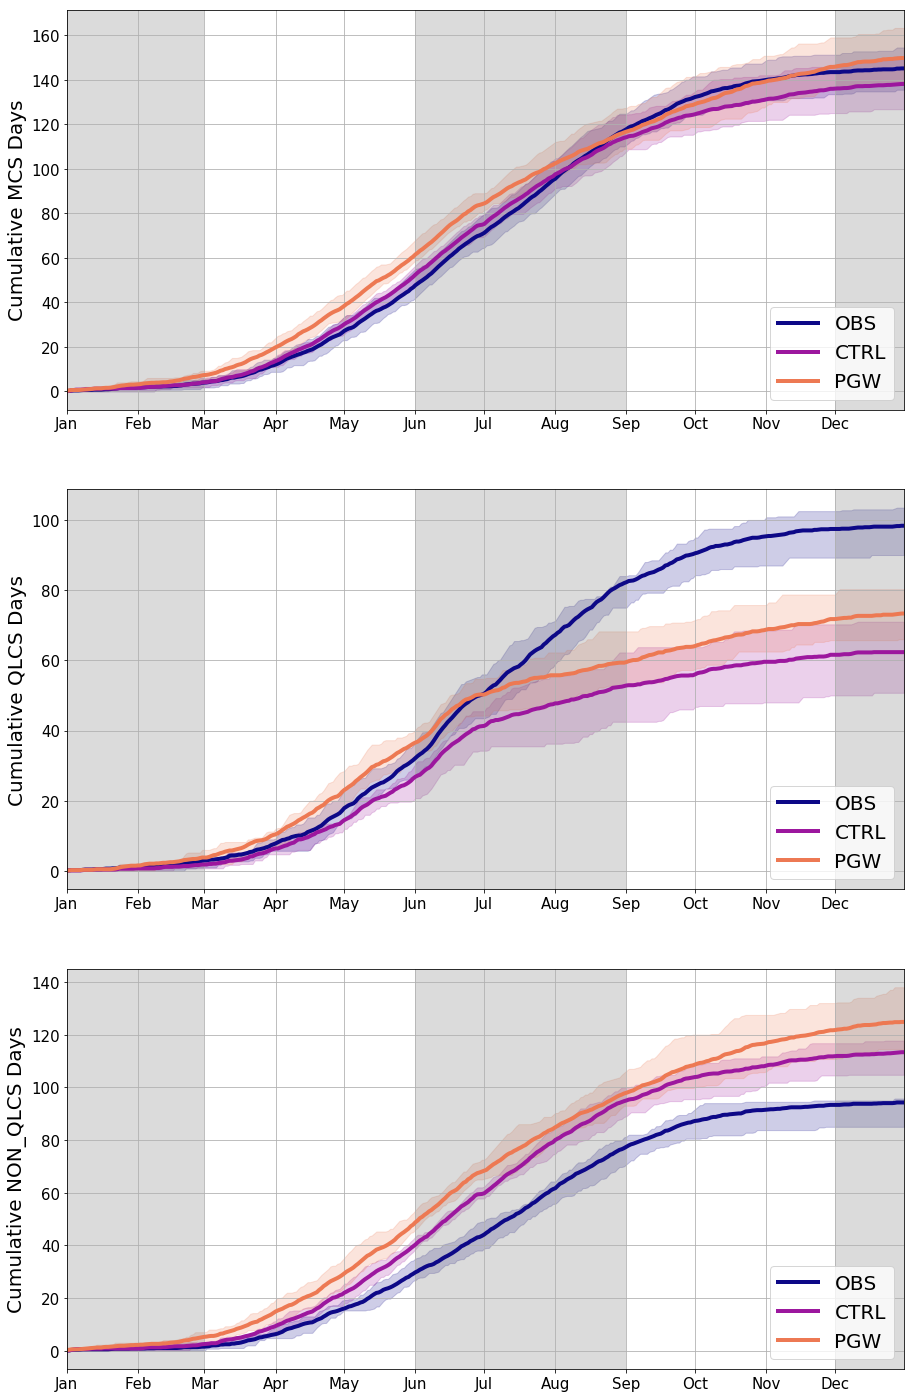

In [13]:
import datetime
from pandas.plotting import register_matplotlib_converters as pdtc
import matplotlib.dates as mdates
pdtc()
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = 15, 25
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

month_doy = {'Jan':1, 'Feb':32, 'Mar':60, 
             'Apr':91, 'May':121, 'Jun':152, 
             'Jul':182, 'Aug':213, 'Sep':244, 
             'Oct':274, 'Nov':305, 'Dec':335}

ax = plt.subplot(1, 1, 1)

drange = pd.date_range(start=datetime.datetime(2000, 10, 1), end=datetime.datetime(2013, 12, 31), freq='D')

colors = [plt.cm.plasma(x/3) for x in range(0, 3)]

def draw_cumu_labels(ax):
    
    ax.legend(loc=4, prop={'size': 20})
    
    ax.axvspan(datetime.datetime(2012, 1, 1), datetime.datetime(2012, 3, 1), facecolor='0.5', alpha=0.1)
    ax.axvspan(datetime.datetime(2012, 6, 1), datetime.datetime(2012, 9, 1), facecolor='0.5', alpha=0.1)
    ax.axvspan(datetime.datetime(2012, 12, 1), datetime.datetime(2012, 12, 31), facecolor='0.5', alpha=0.1)
    ax.grid()
    ax.set_ylabel("Cumulative Count")
    return ax

for subplot, subset in enumerate(['mcs', 'qlcs', 'non_qlcs']):
    ctrl_ = None
    obs_ = None
    maxyear = 0
    for dset_num, dataset in enumerate(['OBS', 'CTRL', 'PGW']):
        
        ax = plt.subplot(3, 1, subplot+1)
        
        #Get run and dataset from Midwest subset
        df_ = mw_data[subset][dataset].copy()
        df_.index = df_.index + datetime.timedelta(hours=6)
        df_ = df_[~((df_.index.year == 2000) | (df_.index.year == 2013))]
    
        years = df_.groupby(df_.index.year)

        dset = []

        for yid, year in years:

            a = year.resample('D').count()
            rng = pd.DataFrame(index=pd.date_range(start=str(yid) + '-01-01', end=str(yid) + '-12-31', freq='1D'))
            rng = rng.join(a[['storm_num']])
            rng = rng.fillna(0)
            rng['storm_num'] = 1*(rng['storm_num'].values>0)

            dset.append(rng.cumsum())

        dset = pd.concat(dset)
        dset['doy'] = dset.index.dayofyear

        p25 = []
        p75 = []
        mean = []
        for did, doy in dset.groupby('doy'):
            p25.append(np.percentile(doy.storm_num, 25))
            p75.append(np.percentile(doy.storm_num, 75))
            mean.append(np.mean(doy.storm_num))

        mean[-1] = mean[-2]
        p25[-1] = p25[-2]
        p75[-1] = p75[-2]
        
        ax.fill_between(rng.index.to_pydatetime(), p25, p75, color=colors[dset_num], alpha=0.2)
        ax.plot(rng.index.to_pydatetime(), mean, '-', color=colors[dset_num], linewidth=4, label=dataset)
        draw_cumu_labels(ax)
        
        if dataset == 'OBS':
            obs_ = mean
        elif dataset == 'CTRL':
            ctrl_ = mean
        

    jan_sep_dif_obs = obs_[month_doy['Sep']] - obs_[month_doy['Jan']]
    mar_may_dif_obs = obs_[month_doy['Jun']] - obs_[month_doy['Mar']]
    aug_jun_dif_obs = obs_[month_doy['Sep']] - obs_[month_doy['Jun']]
    
    jan_sep_dif_ctrl = ctrl_[month_doy['Sep']] - ctrl_[month_doy['Jan']]
    mar_may_dif_ctrl = ctrl_[month_doy['Jun']] - ctrl_[month_doy['Mar']]
    aug_jun_dif_ctrl = ctrl_[month_doy['Sep']] - ctrl_[month_doy['Jun']]
    
    print("JJA OBS: ", subset, aug_jun_dif_obs)
    print("JJA CTRL: ", subset, aug_jun_dif_ctrl)
    
    print("Jan-Sept OBS - CTRL Diff for:", subset, jan_sep_dif_obs - jan_sep_dif_ctrl)
    print("MAM OBS - CTRL Diff for:", subset, mar_may_dif_obs - mar_may_dif_ctrl)
    print("JJA OBS - CTRL Diff for:", subset, aug_jun_dif_obs - aug_jun_dif_ctrl)
        
    ax.set_xlim(rng.index[0], rng.index[-1])
    ax.set_ylabel("Cumulative " + subset.upper() + " Days", fontsize=20)
    locator = mdates.MonthLocator()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    
plt.savefig("Figure1.tif", dpi=400, bbox_inches='tight')

# Calculate hourly percentages (JJA)

In [14]:
col_names = ['key'] + [str(x) for x in range(0, 24)]

hours = {x:[] for x in col_names}

for sub_key in ['mcs', 'qlcs', 'non_qlcs']:
    for dset_key in ['OBS', 'CTRL', 'PGW']:

        dset_val = mw_data[sub_key][dset_key].copy()
        dset_val = dset_val[dset_val.index.month.isin([6,7,8])]
        total_count = 1196

        for hr in list(range(0, 24)):
            
            dset_ = dset_val[dset_val.index.hour==hr]
            
            hours[str(hr)].append(100*(calc_day_count(dset_) / total_count))
            
        hours['key'].append(sub_key + "_" + dset_key)

df = pd.DataFrame.from_dict(hours)
df = df.set_index('key')

for gid, group in df.groupby(df.index):
    
    max_idx = group.idxmax(axis=1).values[0]
    min_idx = group.idxmin(axis=1).values[0]
    
    max_val = group.max(axis=1).values[0]
    min_val = group.min(axis=1).values[0]
    
    print(gid, "\nMax:", max_idx.zfill(2), "z - Max %", max_val, 
               "\nMin:", min_idx.zfill(2), "z - Min %", min_val, '\nMax % Diff', max_val - min_val, '\n')
df

mcs_CTRL 
Max: 02 z - Max % 48.8294314381 
Min: 15 z - Min % 21.8227424749 
Max % Diff 27.0066889632 

mcs_OBS 
Max: 07 z - Max % 53.6789297659 
Min: 19 z - Min % 23.5785953177 
Max % Diff 30.1003344482 

mcs_PGW 
Max: 02 z - Max % 42.3076923077 
Min: 17 z - Min % 23.2441471572 
Max % Diff 19.0635451505 

non_qlcs_CTRL 
Max: 01 z - Max % 35.4515050167 
Min: 15 z - Min % 14.6321070234 
Max % Diff 20.8193979933 

non_qlcs_OBS 
Max: 07 z - Max % 21.237458194 
Min: 19 z - Min % 9.44816053512 
Max % Diff 11.7892976589 

non_qlcs_PGW 
Max: 01 z - Max % 31.1036789298 
Min: 17 z - Min % 14.9665551839 
Max % Diff 16.1371237458 

qlcs_CTRL 
Max: 01 z - Max % 21.9063545151 
Min: 15 z - Min % 8.61204013378 
Max % Diff 13.2943143813 

qlcs_OBS 
Max: 06 z - Max % 38.127090301 
Min: 18 z - Min % 14.7157190635 
Max % Diff 23.4113712375 

qlcs_PGW 
Max: 02 z - Max % 18.6454849498 
Min: 17 z - Min % 9.94983277592 
Max % Diff 8.69565217391 



,0,1,10,11,12,13,14,15,16,17,...,21,22,23,3,4,5,6,7,8,9
key,,,,,,,,,,,,,,,,,,,,,
mcs_OBS,41.722408,45.568562,48.411371,45.652174,42.642140,39.381271,35.200669,30.602007,27.006689,24.247492,...,29.933110,33.444816,37.207358,48.662207,50.752508,51.337793,52.591973,53.678930,52.173913,50.334448
mcs_CTRL,46.906355,48.578595,31.605351,30.183946,28.344482,26.421405,23.913043,21.822742,21.989967,21.989967,...,33.779264,38.043478,43.561873,47.324415,45.401338,43.478261,40.802676,38.712375,36.371237,33.946488
mcs_PGW,39.799331,41.806020,32.357860,30.769231,29.765886,28.678930,26.923077,24.832776,24.163880,23.244147,...,30.852843,35.284281,37.541806,41.973244,40.886288,38.043478,36.705686,34.949833,33.528428,32.943144
qlcs_OBS,29.431438,33.612040,33.110368,29.598662,26.839465,25.000000,21.488294,18.394649,16.220736,15.217391,...,19.147157,22.324415,26.003344,35.953177,37.290970,37.458194,38.127090,37.959866,37.040134,35.117057
qlcs_CTRL,20.150502,21.906355,13.963211,12.541806,12.123746,10.702341,9.448161,8.612040,8.612040,8.779264,...,13.210702,14.882943,18.143813,21.655518,21.070234,20.066890,18.478261,17.809365,16.471572,15.468227
qlcs_PGW,17.056856,17.892977,14.297659,13.294314,12.207358,11.705686,11.120401,10.451505,10.451505,9.949833,...,11.705686,13.963211,16.137124,18.645485,18.311037,17.976589,17.307692,16.806020,16.555184,16.053512
non_qlcs_OBS,16.638796,18.561873,20.066890,20.568562,19.565217,17.391304,16.304348,14.130435,11.956522,10.284281,...,13.127090,14.046823,14.799331,19.230769,20.234114,20.066890,20.317726,21.237458,20.903010,20.317726
non_qlcs_CTRL,33.862876,35.451505,20.652174,19.983278,18.394649,17.391304,15.969900,14.632107,14.715719,14.799331,...,24.665552,28.260870,31.688963,33.612040,31.688963,30.016722,27.591973,25.501672,23.662207,21.822742
non_qlcs_PGW,29.347826,31.103679,22.324415,21.488294,20.903010,20.066890,18.478261,16.555184,15.468227,14.966555,...,22.826087,26.170569,27.341137,30.183946,28.846154,25.836120,24.331104,22.575251,21.655518,21.571906


# Calculate hourly min/max differences in Days per year (JJA) 

In [15]:
shrs = [str(x) for x in range(0, 24)]
col_names = ['subset', 'dset'] + shrs

hours = {x:[] for x in col_names}

for sub_key in ['mcs', 'qlcs', 'non_qlcs']:
    for dset_key in ['OBS', 'CTRL', 'PGW']:

        dset_val = mw_data[sub_key][dset_key].copy()
        dset_val = dset_val[dset_val.index.month.isin([6,7,8])].copy()
        total_count = 1196

        for hr in list(range(0, 24)):
            
            dset_ = dset_val[dset_val.index.hour==hr].copy()
            
            hours[str(hr)].append(calc_day_count(dset_))
            
        hours['subset'].append(sub_key)
        hours['dset'].append(dset_key)

df = pd.DataFrame.from_dict(hours)

for sset in ['mcs', 'qlcs', 'non_qlcs']:
    
    obs = df[(df.dset=='OBS') & (df.subset==sset)]
    ctrl = df[(df.dset=='CTRL') & (df.subset==sset)]
    
    diff = np.abs(obs[shrs].values - ctrl[shrs].values)
    
    max_idx = np.argmax(diff)
    min_idx = np.argmin(diff)
    
    max_val = np.max(diff) / 13
    min_val = np.min(diff) / 13
    
    print(sset, "\nMax:", max_idx, "z - Max ", max_val, 
               "\nMin:", min_idx, "z - Min ", min_val)

print("\nTotals")
print("\n", df[col_names[:10]])
print("\n", df[col_names[:2] + col_names[10:18]])
print("\n", df[col_names[:2] + col_names[18:]])

mcs 
Max: 10 z - Max  15.4615384615 
Min: 18 z - Min  0.538461538462
qlcs 
Max: 8 z - Max  18.9230769231 
Min: 20 z - Min  5.15384615385
non_qlcs 
Max: 0 z - Max  15.8461538462 
Min: 13 z - Min  0.0

Totals

      subset  dset    0    1    2    3    4    5    6    7
0       mcs   OBS  499  545  568  582  607  614  629  642
1       mcs  CTRL  561  581  584  566  543  520  488  463
2       mcs   PGW  476  500  506  502  489  455  439  418
3      qlcs   OBS  352  402  416  430  446  448  456  454
4      qlcs  CTRL  241  262  260  259  252  240  221  213
5      qlcs   PGW  204  214  223  223  219  215  207  201
6  non_qlcs   OBS  199  222  232  230  242  240  243  254
7  non_qlcs  CTRL  405  424  415  402  379  359  330  305
8  non_qlcs   PGW  351  372  365  361  345  309  291  270

      subset  dset    8    9   10   11   12   13   14   15
0       mcs   OBS  624  602  579  546  510  471  421  366
1       mcs  CTRL  435  406  378  361  339  316  286  261
2       mcs   PGW  401  394  387  3

# Draw hourly counts of events

C:\Users\ahaberlie\Anaconda3\envs\py35\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


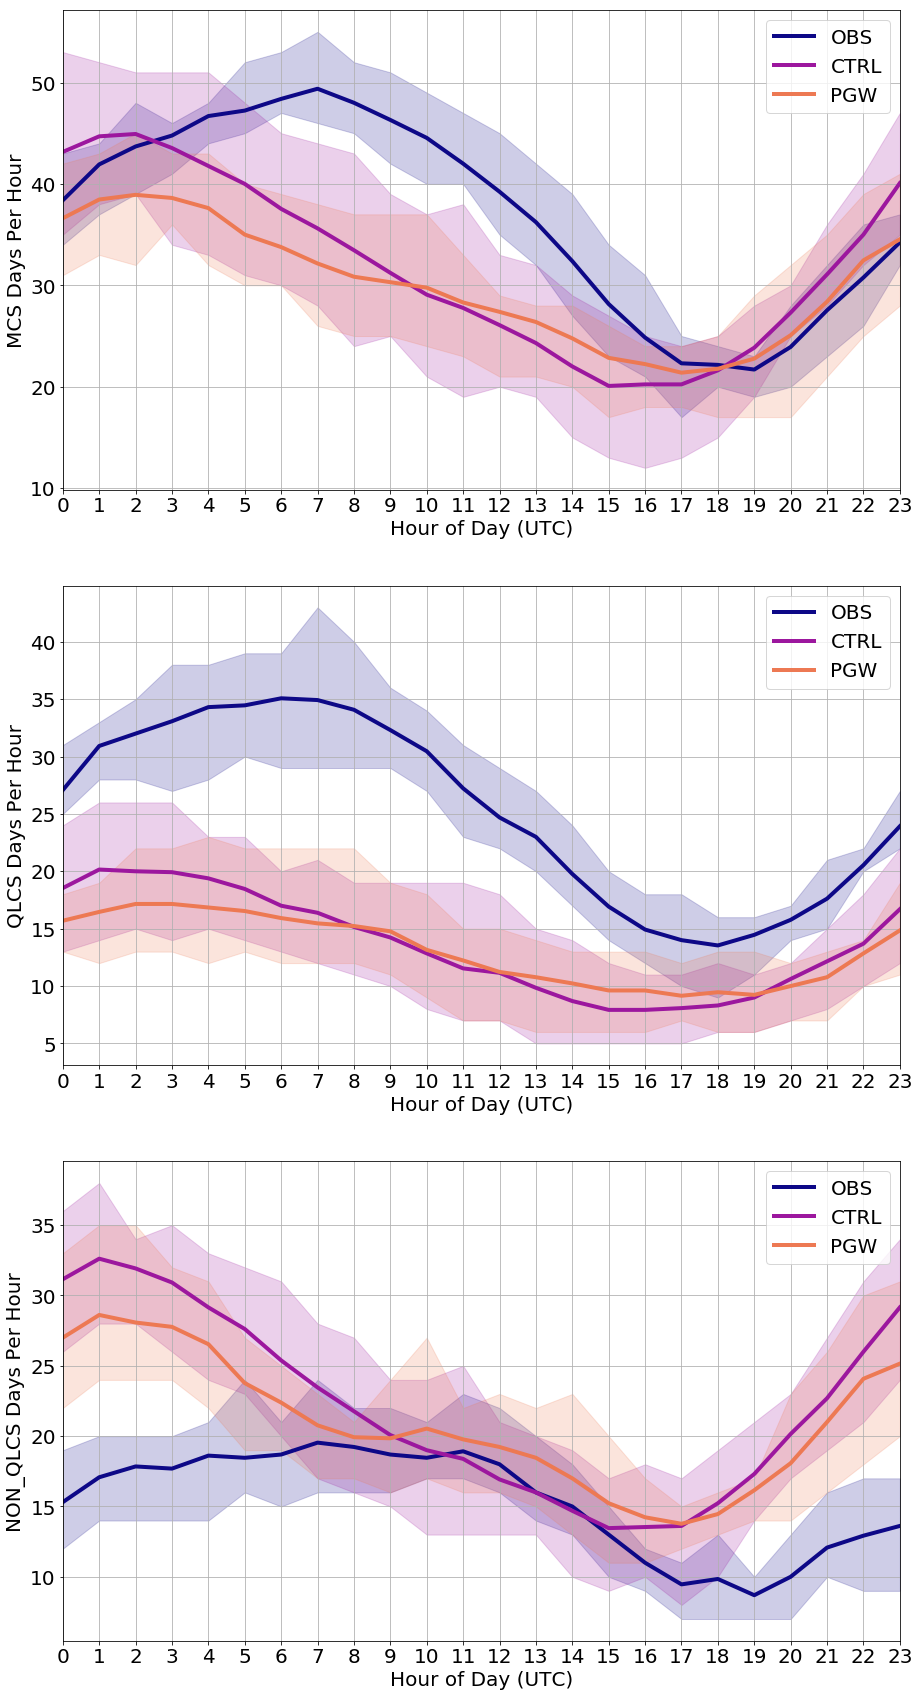

In [16]:
plt.rcParams['figure.figsize'] = 15, 30
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 20

def draw_hour_labels(ax, lab):
    ax.set_xlim(0, 23)
    ax.legend(prop={'size': 20})

    ax.set_ylabel(lab + " Days Per Hour")
    ax.set_xlabel("Hour of Day (UTC)")
    ax.set_xticks(list(range(0, 24)))
    #ax.set_title(lab + " Swath Count by Hour of Day", fontsize=20)
    ax.grid()

colors = [plt.cm.plasma(x/3) for x in range(0, 3)]

for subplot, subset in enumerate(['mcs', 'qlcs', 'non_qlcs']):
    for dset_num, dataset in enumerate(['OBS', 'CTRL', 'PGW']):
        
        ax = plt.subplot(3, 1, subplot+1)
        
        df_ = mw_data[subset][dataset].copy()
        df_ = df_[df_.index.month.isin([6,7,8])].copy()

        years = df_.groupby(df_.index.year)
        year_data = np.zeros((13, 24), dtype=int)
        
        for yid, year in years:
            hour_data = []
            for hid in range(0, 24):

                hour = year[year.index.hour==hid]
                hour_data.append(calc_day_count(hour))
                
            year_data[yid-2001, :] = np.array(hour_data)

        p25 = np.percentile(year_data, 25, axis=0)
        p75 = np.percentile(year_data, 75, axis=0)
        plt.fill_between(list(range(24)), p25, p75, color=colors[dset_num], alpha=0.2)
        plt.plot(np.mean(year_data, axis=0), '-', color=colors[dset_num], linewidth=4, label=dataset)
        
        ax = draw_hour_labels(ax, subset.upper())
        
plt.savefig("Figure2.tif", dpi=400, bbox_inches='tight')